In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
project_dir = os.getcwd().split('\\')[:-1]
project_dir = '\\'.join(project_dir)
data_dir = project_dir + '\\data'
processed_dir = data_dir + '\\processed'
processed_files = os.listdir(processed_dir)
processed_files = [file for file in processed_files if file.endswith('hdf') and file.startswith('processed_')]

In [3]:
WINDOW = 180
STEP = 0.7
df = pd.read_hdf(f'{processed_dir}\\processed_window_{WINDOW}_step_{int(WINDOW * STEP)}.hdf')
features = ['mean_AU01', 'mean_change_AU01', 'mean_AU02', 'mean_change_AU02', 'mean_AU04',
           'mean_change_AU04', 'mean_AU05', 'mean_change_AU05', 'mean_AU06',
           'mean_change_AU06', 'mean_AU07', 'mean_change_AU07', 'mean_AU09',
           'mean_change_AU09', 'mean_AU10', 'mean_change_AU10', 'mean_AU12',
           'mean_change_AU12', 'mean_AU14', 'mean_change_AU14', 'mean_AU15',
           'mean_change_AU15', 'mean_AU17', 'mean_change_AU17', 'mean_AU20',
           'mean_change_AU20', 'mean_AU23', 'mean_change_AU23', 'mean_AU25',
           'mean_change_AU25', 'mean_AU26', 'mean_change_AU26', 'mean_AU45',
           'mean_change_AU45', 'std_AU01', 'std_AU02', 'std_AU04', 'std_AU05',
           'std_AU06', 'std_AU07', 'std_AU09', 'std_AU10', 'std_AU12', 'std_AU14',
           'std_AU15', 'std_AU17', 'std_AU20', 'std_AU23', 'std_AU25', 'std_AU26',
           'std_AU45', 'mean_Arousal', 'mean_Happy', 'mean_Sad', 'mean_Angry',
           'mean_Scared', 'std_pose_Tx', 'std_pose_Ty', 'std_pose_Tz',
           'std_pose_Rx', 'std_pose_Ry', 'std_pose_Rz', 'compound_Motion',
           'mean_PD', 'std_PD', 'max_PD', 'blink_rate', 'per_EC', 'leeftijd', 'geslacht']
targets = ['mean_SCL', 'corrected_mean_SCL', 'range_corrected_mean_SCL', 'standardised_mean_scl',
           'frequency_NS_SCR', 'HRV_MeanNN', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_MeanNN_corrected',
           'HRV_RMSSD_corrected', 'HRV_SDNN_corrected']
cols = features + targets + ['pp']
data = df[cols]

In [4]:
testset_pp = random.sample(list(df.pp.unique()), 10)

# test_df = df[df.pp.isin(testset_pp)]
# train_df = df[~df.pp.isin(testset_pp)]

start_test_df = df[df.pp.isin(testset_pp)]
start_train_df = df[~df.pp.isin(testset_pp)]

In [5]:
for target in targets:
    print(f'Finding best RF model for: {target}')
    M = start_train_df[target].mean()
    SD = start_train_df[target].std()
    
    train_df = start_train_df[(start_train_df[target]< M + 3*SD) & (start_train_df[target]>M - 3*SD)]
    
    
    LPSO = GroupKFold(n_splits=5)
    split_iter = LPSO.split(train_df[features], train_df[target], train_df.pp)

    RMSE = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

    tuned_parameters = [{'max_depth': [None, 4],
                         'min_samples_split':[2, 5, 10],
                         'max_features': [0.1, 0.5, 0.9]}]

    regression = GridSearchCV(RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=5000), tuned_parameters, verbose=1, n_jobs=-1, cv=split_iter)

    regression.fit(train_df[features], train_df[target])
    
    print("Best parameters set found on validation set:")
    print(regression.best_params_)
    print("Best score found on validation set:")
    print(regression.best_score_)
    
    test_df = start_test_df
    
    pred_y = regression.best_estimator_.predict(X=test_df[features])
    true_y = test_df[target]

    print(f'\nR Squared found on test data: \n{regression.best_estimator_.score(X=test_df[features], y=test_df[target])}')
    print(f'RMSE found on test data: \n{mean_squared_error(y_true=test_df[target], y_pred=regression.best_estimator_.predict(X=test_df[features]))}\n')
    
    print('Saving predictions from best model on test dataset.')

    pps = test_df.pp
    new_data = pd.DataFrame({'true_y': true_y, 'predicted_y': pred_y})
    new_data['target'] = target
    predicted_data = pd.concat([predicted_data, new_data], join='outer', ignore_index=True)

predicted_data.to_hdf(f'{processed_dir}\\predicted_data_RF_{WINDOW}_{int(WINDOW*STEP)}.hdf', "data", mode="w")

Finding best RF model for: mean_SCL
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 10}
Best score found on validation set:
-0.0757664621104965

R Squared found on test data: 
-0.1385945171912657
RMSE found on test data: 
16.324564964742642

Saving predictions from best model on test dataset.
Finding best RF model for: corrected_mean_SCL
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.9min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 10}
Best score found on validation set:
-0.31696618191269227

R Squared found on test data: 
-0.2717187512292858
RMSE found on test data: 
2.512283296487829

Saving predictions from best model on test dataset.
Finding best RF model for: range_corrected_mean_SCL
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.7min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.9, 'min_samples_split': 5}
Best score found on validation set:
-0.0428485034633036

R Squared found on test data: 
-0.027051504205163113
RMSE found on test data: 
0.22243027282942124

Saving predictions from best model on test dataset.
Finding best RF model for: standardised_mean_scl
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 10}
Best score found on validation set:
0.07879568019826629

R Squared found on test data: 
-0.030207245624947143
RMSE found on test data: 
5.939704259039076

Saving predictions from best model on test dataset.
Finding best RF model for: frequency_NS_SCR
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


Best parameters set found on validation set:
{'max_depth': None, 'max_features': 0.1, 'min_samples_split': 2}
Best score found on validation set:
-0.04767782886104166

R Squared found on test data: 
-0.10581162006313005
RMSE found on test data: 
8.814179440130657

Saving predictions from best model on test dataset.
Finding best RF model for: HRV_MeanNN
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


Best parameters set found on validation set:
{'max_depth': None, 'max_features': 0.1, 'min_samples_split': 10}
Best score found on validation set:
-0.03262319537137617

R Squared found on test data: 
-0.10816665397919567
RMSE found on test data: 
187846.77416102108

Saving predictions from best model on test dataset.
Finding best RF model for: HRV_RMSSD
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 10}
Best score found on validation set:
-0.24208883964433517

R Squared found on test data: 
-0.09247721909191609
RMSE found on test data: 
1089.8449981982526

Saving predictions from best model on test dataset.
Finding best RF model for: HRV_SDNN
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 2}
Best score found on validation set:
-0.05667584401979135

R Squared found on test data: 
-0.2289212853373097
RMSE found on test data: 
3068.506987111622

Saving predictions from best model on test dataset.
Finding best RF model for: HRV_MeanNN_corrected
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 2}
Best score found on validation set:
-0.2689763651728654

R Squared found on test data: 
-0.07771171488406581
RMSE found on test data: 
30171.982064588334

Saving predictions from best model on test dataset.
Finding best RF model for: HRV_RMSSD_corrected
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 10}
Best score found on validation set:
-0.28785908089525303

R Squared found on test data: 
-0.25642873528472543
RMSE found on test data: 
1759.2007510057435

Saving predictions from best model on test dataset.
Finding best RF model for: HRV_SDNN_corrected
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


Best parameters set found on validation set:
{'max_depth': 4, 'max_features': 0.1, 'min_samples_split': 2}
Best score found on validation set:
-0.17948297394243662

R Squared found on test data: 
-0.07102952257178008
RMSE found on test data: 
1651.6578595352933

Saving predictions from best model on test dataset.


In [6]:
# print("Best parameters set found on development set:")
# print(regression.best_params_)
# print("Grid scores on development set:")
# means = regression.cv_results_['mean_test_score']
# stds = regression.cv_results_['std_test_score']

# for mean, std, params in zip(means, stds, regression.cv_results_['params']):
#     print(f"{mean:0.3f} (+/-{std * 2:0.3f}) for {params}")
    
# print(f'R Squared on test data: {regression.best_estimator_.score(X=test_df[features], y=test_df[target])}')

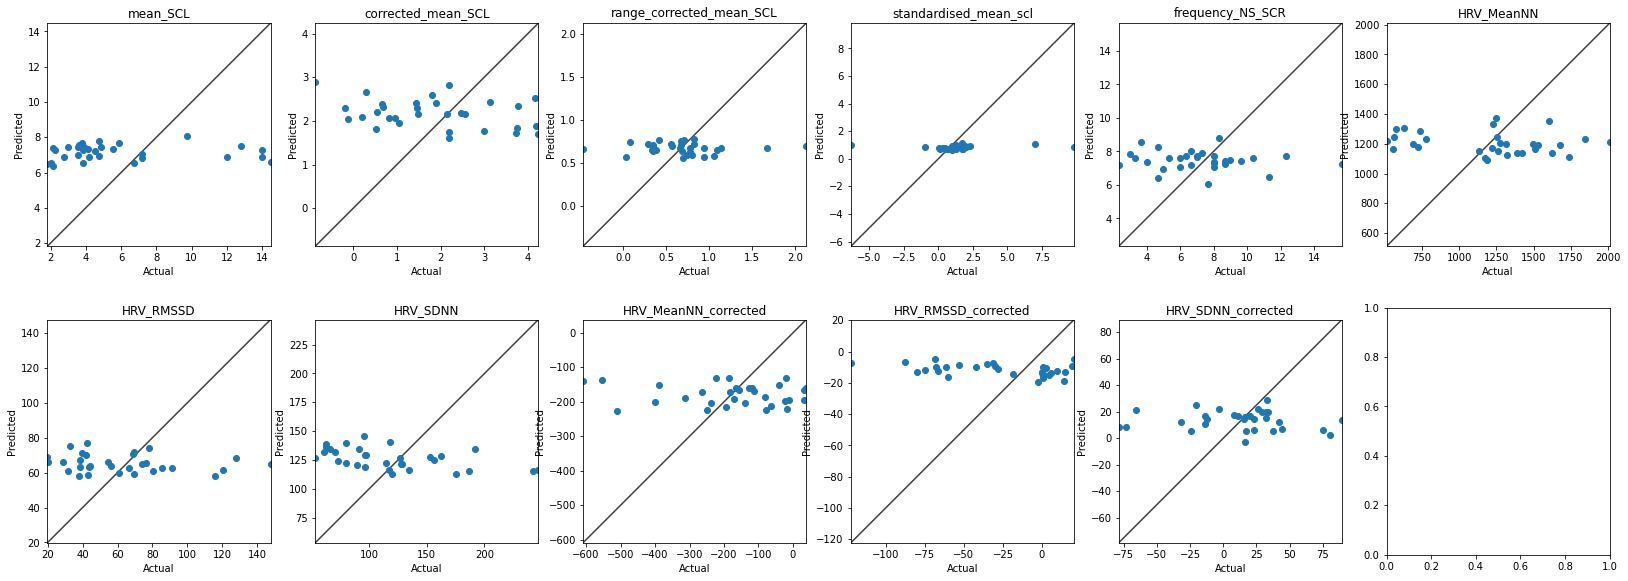

In [7]:
f, axes = plt.subplots(2, 6, figsize=(28,10))
for i in range(len(targets)):
    target = targets[i]
    vmin = predicted_data.loc[predicted_data.target==target, ['true_y', 'predicted_y']].min().min()
    vmax = predicted_data.loc[predicted_data.target==target, ['true_y', 'predicted_y']].max().max()
    ax = axes[int(i/6), i%6]
    ax.scatter(x = predicted_data.loc[predicted_data.target==target, 'true_y'], y = predicted_data.loc[predicted_data.target==target, 'predicted_y'])
    ax.set_title(target)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.plot((vmin, vmax),(vmin, vmax), 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
plt.savefig(f'{project_dir}\\reports\\figures\\RF_predicted_data_{WINDOW}_{int(WINDOW*STEP)}.jpg')